# Overview
In this assignment you will implement a simple linear neural network that reads in text and uses pretrained embeddings to predict the **happiness intensity** of the text.
You'll fit the network weights using the analytic expression for linear regression with L2 regularization we discussed in class.

For this assignment we will use the functionality of PyTorch, HuggingFace "transformers" library for getting pretrained models, "pandas" for data loading, matplotlib for visualization. Before you start, make sure you have installed all those packages in your local Jupyter instance. Or use Google Colab (which has everything you need pre-installed).

Read **all** cells carefully and answer **all** parts (both text and missing code). You will complete all the code marked `TODO` and print desired results.

### Exporting the Notebook to PDF
To generate a nice looking PDF of your completed notebook, either use "Print as PDF" from Google colab (using Chrome), or if you are running locally, run the following command in the last cell:
```python
!jupyter nbconvert --to pdf --output=yourname_submission.pdf hw1.ipynb
```

In [3]:
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, HTML

display(HTML("""
<style>
div.output pre {
    white-space: pre-wrap;      /* Wrap long lines */
    word-break: break-word;     /* Break words if necessary */
}
</style>
"""))  # prevent long lines from making unreadable PDF subs


# **Getting and processing data**


In [4]:
# Load dataset and visualize
train_file = 'EI-reg-En-joy-train.txt'
val_file = '2018-EI-reg-En-joy-dev.txt'
df_train = pd.read_csv(train_file, sep='\t')
df_val = pd.read_csv(val_file, sep='\t')

tweets_train = df_train['Tweet'].tolist()  # Create a list of tweets
tweets_val = df_val['Tweet'].tolist()

# Create a list of intensity scores
y_train = torch.tensor(df_train['Intensity Score'], dtype=torch.float32)  # match to dtype of embedding
y_val = torch.tensor(df_val['Intensity Score'], dtype=torch.float32)

print('Score - Tweet')
for i in range(5):
    print('{:0.2f} - {}'.format(y_train[i], tweets_train[i]))

Score - Tweet
0.14 - @david_garrett Quite saddened.....no US dates, no joyous anticipation of attending a DG concert (since 2014). Happy you are keeping busy.
0.79 - 2 days until #GoPackGo and 23 days until #GoGipeGo..... I'm so excited! 
0.27 - Positive #psychology research shows salespeople who score in the top 10% for #optimism have 88% &gt; sales than those in top 10% for pessimism.
0.48 - As the birds chirp and the cows moo we need to listen to the sound of nature to ensure that all is well.
0.94 - Howling with laughter at “WELL DONE BEZZA!” #bakeoff #GBBO


In [5]:
print(len(tweets_train)); print(y_train.shape)

1616
torch.Size([1616])


## Embedding Model :
load a pretrained model and write a function that embeds sentences into vector space

In [6]:
# 1. Embedding model :
from transformers import AutoTokenizer, AutoModel

model_name = "sentence-transformers/all-MiniLM-L6-v2"  # Many possibilities on huggingface.com
tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = AutoModel.from_pretrained(model_name)
def embed_sentence(embedding_model, tokenizer, sentence):
    """Function to embed a sentence as a vector using a pre-trained model."""
    input_id_tensor=tokenizer(sentence,return_tensors='pt')['input_ids']
    with torch.no_grad():
        output=embedding_model(input_id_tensor).last_hidden_state
    mean_embeddings=output.mean(dim=1)
    return mean_embeddings

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [7]:
## Check the embedding function:
s=tweets_train[0]
embed_sentence(embedding_model,tokenizer,s)

s1=tweets_train[:10]
tensor_list=[]
for s in s1:
    es=embed_sentence(embedding_model,tokenizer,s)
    print(es.shape)
    tensor_list.append(es)
stacked_embeddings=torch.vstack(tensor_list)
print(stacked_embeddings.shape)  # should be (10, embedding_dim)



torch.Size([1, 384])
torch.Size([1, 384])
torch.Size([1, 384])
torch.Size([1, 384])
torch.Size([1, 384])
torch.Size([1, 384])
torch.Size([1, 384])
torch.Size([1, 384])
torch.Size([1, 384])
torch.Size([1, 384])
torch.Size([10, 384])


In [8]:
# 2.Use embedding model to turn text into a matrix of embeddings.
# Create a pytorch matrix where each row corresponds to a tweet,
# and the number of columns/features is the size of the embedding

X_train =  torch.vstack([embed_sentence(embedding_model,tokenizer,s) for s in tweets_train])
X_val =  torch.vstack([embed_sentence(embedding_model,tokenizer,s) for s in tweets_val])

print(X_train.shape, X_val.shape)  # torch.Size([1616, 384]) torch.Size([290, 384])

torch.Size([1616, 384]) torch.Size([290, 384])


# Define the Regression model :
The model implements a linear model $$\hat{y}(x) = \mathbf w \cdot \mathbf x + b.$$ The "fit" method should use the analytic formula discussed in class to minimize the loss, $$L(\mathbf w, b) = \sum_{i=1}^N (y_i -  \hat y(\mathbf x_i))^2 + \gamma (\sum_{j=1}^d w_i^2 + b^2)$$
Our L2 regularizer is applied to all the parameters for simplicity. But note that it is common to only apply L2 regularization to the weights and not the biases.

In [9]:
## check codes:
X = X_train ; y = y_train
ones = torch.ones(X.shape[0], 1)
X_aug = torch.cat([X, ones], dim=1)
print(X_aug.shape)  # should be (1616, embedding_dim + 1)

gamma = 0.0  # regularization strength
#Analytic solution: (X^T X + gamma*I)^-1 * X^T * y
d_aug = X_aug.shape[1]
print(d_aug)  # should be embedding_dim + 1
I = torch.eye(d_aug)
# Solving: w = inv(X_aug.T @ X_aug + gamma * I) @ X_aug.T @ y
XTX_reg = X_aug.t() @ X_aug + gamma * I
print(XTX_reg.shape)
XTX_reg_inv = torch.linalg.inv(XTX_reg)
print(XTX_reg_inv.shape)
w= XTX_reg_inv @ X_aug.t() @ y
print(w.shape)  # should be (embedding_dim + 1, )


torch.Size([1616, 385])
385
torch.Size([385, 385])
torch.Size([385, 385])
torch.Size([385])


In [10]:
class MyLinearNet(torch.nn.Module):
    def __init__(self, input_embedding_size):
        super().__init__()  # init superclass - enables many pytorch model capabilities
        self.d = input_embedding_size  # Often convenient to store this (not a "Parameter" though as we don't train it)
        # TODO [1 point]: define weights and bias with "Parameters"
        self.w = torch.nn.Parameter(torch.randn(self.d))  # weights
        self.b = torch.nn.Parameter(torch.randn(()))  # bias


    def forward(self, x):
        """Implement a linear model"""
        # TODO [1 point]: implement linear model, in terms of weights and biases
        # It should work on a single x, or a batch
        y_hat = x @ self.w + self.b  # shape (batch_size,)
        return y_hat

    def fit(self, X, y, gamma=0.):
        """Given a data matrix, X, and a vector of labels for each row, y,
        analytically fit the parameters of the linear model.
        Use an L2 regularizer with strength 'gamma'."""
        # TODO [3 points]: Use linear regression formula to set weight and bias parameters

        # (a) First, construct the augmented data matrix as discussed in class
        ones = torch.ones(X.shape[0], 1)
        X_aug = torch.cat([X, ones], dim=1)  # shape (n, d+1)
        # (b) Next, use matrix multiplication and torch.linalg.inv to implement the analytic solution
        #Analytic solution: (X^T X + gamma*I)^-1 * X^T * y
        d_aug = X_aug.shape[1]
        I = torch.eye(d_aug)
        # Solving: w = inv(X_aug.T @ X_aug + gamma * I) @ X_aug.T @ y
        A = X_aug.t() @ X_aug + gamma * I
        B= X_aug.t() @ y
        w = torch.linalg.solve(A, B)  # shape (d_aug,)
        # Note the size should be d+1, as the bias is included

        # (c) Put the solution (which includes weights and biases) into parameters
        # Use "data" to update parameters without affecting computation graph
        # (Kind of a subtle point - no need to modify my code below)
        self.w.data = w[:self.d]
        self.b.data = w[-1]



# --- Gemini UNIT TEST FOR MyLinearNet ---
# This cell checks if your model structure is correct before training. No need to modify.
def test_my_linear_net():
    print("Testing MyLinearNet...")
    d_test = 10
    model_test = MyLinearNet(d_test)

    # 1. Check Parameter Shapes
    assert model_test.w.shape == (d_test,), f"Weight shape incorrect. Expected ({d_test},), got {model_test.w.shape}"
    assert model_test.b.shape == () or model_test.b.shape == (1,), f"Bias shape incorrect."
    print("  [+] Parameter shapes look good.")

    # 2. Check Forward Pass dimensions
    batch_size = 5
    x_test = torch.randn(batch_size, d_test)
    y_test = model_test(x_test)
    assert y_test.shape == (batch_size,), f"Output shape incorrect. Expected ({batch_size},), got {y_test.shape}"
    print("  [+] Forward pass output dimensions look good.")

    # 3. Check Fit (just that it runs without error on dummy data)
    y_target = torch.randn(batch_size)
    try:
        model_test.fit(x_test, y_target)
        print("  [+] Fit method ran without crashing.")
    except Exception as e:
        print(f"  [-] Fit method crashed: {e}")
        return

    print("Unit test passed! ✅")

test_my_linear_net()

Testing MyLinearNet...
  [+] Parameter shapes look good.
  [+] Forward pass output dimensions look good.
  [+] Fit method ran without crashing.
Unit test passed! ✅


# Results

## 1. First look at training and validation loss

In [11]:
def loss(model, X, y):
    # TODO [1 point]: implement the mean square error loss
    with torch.no_grad():
        y_hat = model(X)
    mse_loss = torch.mean((y_hat - y) ** 2)
    return mse_loss

d = X_train.shape[1]  # embedding dimension
model = MyLinearNet(d)

loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)
print("\nLoss on train and validation BEFORE fitting.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train, loss_val))

model.fit(X_train, y_train,gamma=0.)  # fit without regularization
loss_train = loss(model, X_train, y_train)
loss_val = loss(model, X_val, y_val)
print("\nLoss on train and validation AFTER fitting WITHOUT regularization.\nTrain: {:0.3f}, Val: {:0.3f}".format(loss_train, loss_val))

#model.fit(X_train, y_train, gamma=10.)  # because of how we scaled the loss, the regularizer values could be quite large
#loss_train = loss(model, X_train, y_train)
#loss_val = loss(model, X_val, y_val)
# TODO [4 points]: Show that Train loss is reduced below 0.02
# and Validation loss is reduced below 0.05, at least
# Adjust the regularizer strength to improve validation loss.
print("\nLoss on train and validation AFTER fitting WITH regularization.")


# Check for best gamma value
gammas = [0., 0.01, 0.1, 1., 10., 100., 200., 500.]
train_losses = []
val_losses = []
for gamma in gammas:
    model.fit(X_train, y_train, gamma=gamma)
    train_loss = loss(model, X_train, y_train)
    val_loss = loss(model, X_val, y_val)
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

print("\nResults for different regularization strengths (gamma):")
print("\nGamma\tTrain Loss\tVal Loss")
for g, tr_loss, v_loss in zip(gammas, train_losses, val_losses):
    print("{:0.2f}\t{:0.3f}\t\t{:0.3f}".format(g, tr_loss, v_loss))


Loss on train and validation BEFORE fitting.
Train: 12.764, Val: 13.294

Loss on train and validation AFTER fitting WITHOUT regularization.
Train: 0.014, Val: 0.029

Loss on train and validation AFTER fitting WITH regularization.

Results for different regularization strengths (gamma):

Gamma	Train Loss	Val Loss
0.00	0.014		0.029
0.01	0.014		0.030
0.10	0.014		0.029
1.00	0.014		0.027
10.00	0.016		0.024
100.00	0.022		0.022
200.00	0.025		0.023
500.00	0.032		0.026


In [12]:
final_model = MyLinearNet(X_train.shape[1])
final_model.fit(X_train, y_train, gamma=1.0)  # best gamma from above
print("\nFinal model trained with gamma=1.0")
train_loss = loss(final_model, X_train, y_train)
val_loss = loss(final_model, X_val, y_val)
print("train loss: {:0.3f}, val loss: {:0.3f}".format(train_loss, val_loss))


Final model trained with gamma=1.0
train loss: 0.014, val loss: 0.027


## 2. Visualize correlation between predicted and true labels, y

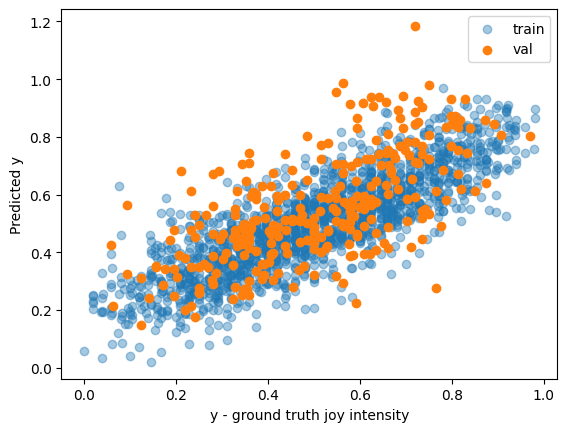

In [13]:
# Use only the regularized model for the results below:

# Create a scatter plot of the actual vs. predicted values of `y` using this function.
def plot(y_train, y_hat_train, y_val, y_hat_val):
    fig, ax = plt.subplots(1)
    ax.scatter(y_train, y_hat_train, alpha=0.4, label='train')
    ax.scatter(y_val, y_hat_val, label='val')
    ax.set_xlabel('y - ground truth joy intensity')
    ax.set_ylabel('Predicted y')
    ax.legend()



with torch.no_grad():
    y_hat_train = final_model(X_train)
    y_hat_val = final_model(X_val)

plot(y_train, y_hat_train, y_val, y_hat_val)

# Model deep dive :
Construct five original sentences and output their happy scores to try to understand how the model works.

In [14]:
# Put in a sample sentence of your own construction and output the "joy meter" for a happy and sad sentence
sentences = [
    "I am sad",
    "dead",
    "happy",
    "dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg",
    "dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg :) :(",
    "dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg happy",
    "Hope the world becomes a better place",
    "I enjoy learning new things"
]

# Print happy score for each sentence
for s in sentences:
    x_s = embed_sentence(embedding_model,tokenizer,s)  # shape (1, embedding_dim)
    with torch.no_grad():
        y_hat_s = final_model(x_s)  # shape (1,)
    print(f"Sentence: '{s}' => Predicted Joy Intensity: {y_hat_s.item():0.3f}")

Sentence: 'I am sad' => Predicted Joy Intensity: -0.187
Sentence: 'dead' => Predicted Joy Intensity: -0.126
Sentence: 'happy' => Predicted Joy Intensity: 0.896
Sentence: 'dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg' => Predicted Joy Intensity: 0.298
Sentence: 'dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg :) :(' => Predicted Joy Intensity: 0.322
Sentence: 'dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg happy' => Predicted Joy Intensity: 0.487
Sentence: 'Hope the world becomes a better place' => Predicted Joy Intensity: 0.264
Sentence: 'I enjoy learning new things' => Predicted Joy Intensity: 0.823


# Compare embeddings:

Tried different embedding model

-    "bert-base-uncased". Famous and a relatively fast model, but not specifically tuned for similarity.
- "sentence-transformers/all-mpnet-base-v2", a strong baseline for sentence embedding, but slower to run than BERT, MiniLM

If you go any bigger, you'll probably need to run on GPUs.
https://huggingface.co/spaces/mteb/leaderboard


## 1.Bert Model


In [15]:
# Get the validation loss using a different text embedding

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = AutoModel.from_pretrained(model_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [16]:
X_train =  torch.vstack([embed_sentence(embedding_model,tokenizer,s) for s in tweets_train])
X_val =  torch.vstack([embed_sentence(embedding_model,tokenizer,s) for s in tweets_val])

print(X_train.shape, X_val.shape)  # torch.Size([1616, 384]) torch.Size([290, 384])

torch.Size([1616, 768]) torch.Size([290, 768])


In [17]:
bert_model = MyLinearNet(X_train.shape[1])
bert_model.fit(X_train, y_train, gamma=0)
train_loss = loss(bert_model, X_train, y_train)
val_loss = loss(bert_model, X_val, y_val)
print("\nBERT Embedding Model - without regularization" \
"\n Train loss: {:0.3f}, Val loss: {:0.3f}".format(train_loss, val_loss))


BERT Embedding Model - without regularization
 Train loss: 0.009, Val loss: 0.044


In [18]:
# Check for best gamma value
gammas = [0., 0.01, 0.1, 1., 10., 100., 200., 500.]
train_losses = []
val_losses = []
for gamma in gammas:
    bert_model.fit(X_train, y_train, gamma=gamma)
    train_loss = loss(bert_model, X_train, y_train)
    val_loss = loss(bert_model, X_val, y_val)
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
print("\nBERT Embedding Model - with regularization")
print("\nResults for different regularization strengths (gamma):")
print("\nGamma\tTrain Loss\tVal Loss")
for g, tr_loss, v_loss in zip(gammas, train_losses, val_losses):
    print("{:0.2f}\t{:0.3f}\t\t{:0.3f}".format(g, tr_loss, v_loss))



BERT Embedding Model - with regularization

Results for different regularization strengths (gamma):

Gamma	Train Loss	Val Loss
0.00	0.009		0.044
0.01	0.009		0.044
0.10	0.009		0.042
1.00	0.010		0.033
10.00	0.013		0.024
100.00	0.018		0.021
200.00	0.021		0.021
500.00	0.024		0.022


In [19]:
#Final model training with best gamma
bert_model.fit(X_train, y_train, gamma=1.0)
train_loss = loss(bert_model, X_train, y_train)
val_loss = loss(bert_model, X_val, y_val)
print("\nFinal BERT model trained with gamma=1.0")
print("train loss: {:0.3f}, val loss: {:0.3f}".format(train_loss, val_loss))


Final BERT model trained with gamma=1.0
train loss: 0.010, val loss: 0.033


In [20]:
# Put in a sample sentence of your own construction and output the "joy meter" for a happy and sad sentence
sentences = [
    "I am sad",
    "dead",
    "happy",
    "dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg",
    "dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg :) :(",
    "dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg happy",
    "Hope the world becomes a better place",
    "I enjoy learning new things"
]

#  Print happy score for each sentence
for s in sentences:
    x_s = embed_sentence(embedding_model,tokenizer,s)  # shape (1, embedding_dim)
    with torch.no_grad():
        y_hat_s = bert_model(x_s)  # shape (1,)
    print(f"Sentence: '{s}' => Predicted Joy Intensity: {y_hat_s.item():0.3f}")

Sentence: 'I am sad' => Predicted Joy Intensity: 0.336
Sentence: 'dead' => Predicted Joy Intensity: 0.206
Sentence: 'happy' => Predicted Joy Intensity: 0.797
Sentence: 'dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg' => Predicted Joy Intensity: 0.394
Sentence: 'dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg :) :(' => Predicted Joy Intensity: 0.456
Sentence: 'dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg happy' => Predicted Joy Intensity: 0.443
Sentence: 'Hope the world becomes a better place' => Predicted Joy Intensity: 0.552
Sentence: 'I enjoy learning new things' => Predicted Joy Intensity: 0.744


## 2. all-mpnet-base-v2 model

In [21]:
model_name = "sentence-transformers/all-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
embedding_model = AutoModel.from_pretrained(model_name)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [22]:
X_train =  torch.vstack([embed_sentence(embedding_model,tokenizer,s) for s in tweets_train])
X_val =  torch.vstack([embed_sentence(embedding_model,tokenizer,s) for s in tweets_val])

print(X_train.shape, X_val.shape)  # torch.Size([1616, 384]) torch.Size([290, 384])

torch.Size([1616, 768]) torch.Size([290, 768])


In [23]:
mpnet_model = MyLinearNet(X_train.shape[1])
mpnet_model.fit(X_train, y_train, gamma=0)
train_loss = loss(mpnet_model, X_train, y_train)
val_loss = loss(mpnet_model, X_val, y_val)
print("\nMPNet Embedding Model - without regularization" \
"\n Train loss: {:0.3f}, Val loss: {:0.3f}".format(train_loss, val_loss))


# Check for best gamma value
gammas = [0., 0.01, 0.1, 1., 10., 100., 200., 500.]
train_losses = []
val_losses = []
for gamma in gammas:
    mpnet_model.fit(X_train, y_train, gamma=gamma)
    train_loss = loss(mpnet_model, X_train, y_train)
    val_loss = loss(mpnet_model, X_val, y_val)
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
print("\nMPNet Embedding Model - with regularization")
print("\nResults for different regularization strengths (gamma):")
print("\nGamma\tTrain Loss\tVal Loss")
for g, tr_loss, v_loss in zip(gammas, train_losses, val_losses):
    print("{:0.2f}\t{:0.3f}\t\t{:0.3f}".format(g, tr_loss, v_loss))


MPNet Embedding Model - without regularization
 Train loss: 0.007, Val loss: 0.039

MPNet Embedding Model - with regularization

Results for different regularization strengths (gamma):

Gamma	Train Loss	Val Loss
0.00	0.007		0.039
0.01	0.007		0.037
0.10	0.007		0.031
1.00	0.009		0.024
10.00	0.013		0.020
100.00	0.021		0.019
200.00	0.025		0.020
500.00	0.033		0.026


In [24]:
# final model training with best gamma
mpnet_model.fit(X_train, y_train, gamma=1.0)
print("\nFinal MPNet model trained with gamma=1.0")
train_loss = loss(mpnet_model, X_train, y_train)
val_loss = loss(mpnet_model, X_val, y_val)
print("train loss: {:0.3f}, val loss: {:0.3f}".format(train_loss, val_loss))


Final MPNet model trained with gamma=1.0
train loss: 0.009, val loss: 0.024


In [25]:
# Put in a sample sentence of your own construction and output the "joy meter" for a happy and sad sentence
sentences = [
    "I am sad",
    "dead",
    "happy",
    "dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg",
    "dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg :) :(",
    "dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg happy",
    "Hope the world becomes a better place",
    "I enjoy learning new things"
]

# Print happy score for each sentence
for s in sentences:
    x_s = embed_sentence(embedding_model,tokenizer,s)  # shape (1, embedding_dim)
    with torch.no_grad():
        y_hat_s = mpnet_model(x_s)  # shape (1,)
    print(f"Sentence: '{s}' => Predicted Joy Intensity: {y_hat_s.item():0.3f}")

Sentence: 'I am sad' => Predicted Joy Intensity: 0.305
Sentence: 'dead' => Predicted Joy Intensity: 0.050
Sentence: 'happy' => Predicted Joy Intensity: 0.649
Sentence: 'dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg' => Predicted Joy Intensity: 0.357
Sentence: 'dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg :) :(' => Predicted Joy Intensity: 0.353
Sentence: 'dgr efef3v sew3defew ssdeereve wecd eveverve cewfrg4rg happy' => Predicted Joy Intensity: 0.482
Sentence: 'Hope the world becomes a better place' => Predicted Joy Intensity: 0.393
Sentence: 'I enjoy learning new things' => Predicted Joy Intensity: 0.534


# Conclusion:


### Model 1 :
* model_name = "sentence-transformers/all-MiniLM-L6-v2"
* regularization with gamma = 1.0
* train loss = 0.014    validation loss = 0.027
* adding regularization decreased the validation loss by ~ 6.9%

### Model 2:
* model_name = "bert-base-uncased"
* regularization with gamma = 1.0
* train loss = 0.010    validation loss =  0.033
* adding regularization decreased the validation loss by ~25%

### Model 3:
* model_name = "sentence-transformers/all-mpnet-base-v2"
* regularization with gamma = 1.0
* train loss = 0.009    validation loss = 0.024
* adding regularization decreased the validation loss by ~38.46%



